# <center> Banglore House Price Prediction - Regression 

### Importing Necessary Libraries 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,10)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

### Importing the Dataset 

In [2]:
df = pd.read_csv('Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


### Basic Information of the Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [4]:
print('The Number of Rows in the Dataset is ',df.shape[0])
print('The Number of Columns in the Dataset is ',df.shape[1])

The Number of Rows in the Dataset is  13320
The Number of Columns in the Dataset is  9


## Data Cleaning

### Finding the Missing Values in the Dataset 

In [5]:
Total = df.isnull().sum().sort_values(ascending=False)
Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)   
missing_data = pd.concat([Total, Percent], axis=1, keys=['Total', 'Percentage of Missing Values'])    
missing_data

,Total,Percentage of Missing Values
society,5502,41.306306
balcony,609,4.572072
bath,73,0.548048
size,16,0.120120
location,1,0.007508
area_type,0,0.000000
availability,0,0.000000
total_sqft,0,0.000000
price,0,0.000000


In [6]:
print('Total Null Values present in the Dataset is',df.isnull().sum().sum())

Total Null Values present in the Dataset is 6201


`For our price predictions we can drop some of the columns in the dataset which are not required to build our model`

In [7]:
df2 = df.drop(['society','balcony','area_type','availability'], axis = 'columns')
print('The Number of Rows and Columns in the Dataset are',df2.shape)

The Number of Rows and Columns in the Dataset are (13320, 5)


#### Checking the Null Values in the Dataset 

In [8]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

`The presence of Null values in the Dataset are fewer and so we can drop the null values in the dataset` 

In [9]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

### Feature Engineering

In [10]:
df3.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [11]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [12]:
def changefloat(x):
    try:
        float(x)
    except:
        return False
    return True

In [13]:
df3[~df3['total_sqft'].apply(changefloat)].head()

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2


In [14]:
df3[~df3['total_sqft'].apply(changefloat)].shape

(190, 6)

`Though the column Total square feet data types are changed some values are not able to be changed and those values shows the range of square feet of house available in a particular place and for our convinence the range mid values are choosen for the further process of the model`

In [15]:
def finding_mid_value(x):
    value = x.split('-')
    if len(value) == 2:
        return (float(value[0]) + float(value[1]))/2
    try:
        return float(x)
    except:
        return None

In [16]:
df3['total_sqft'] = df3.total_sqft.apply(finding_mid_value)
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [17]:
df3 = df3.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

### Checking the Correlation

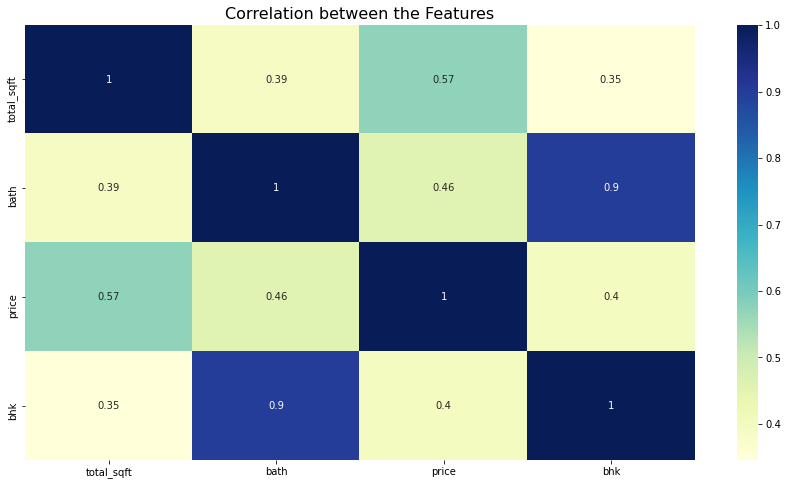

In [18]:
plt.figure(figsize = (15,8))
sns.heatmap(df3.corr(), annot = True, cmap = 'YlGnBu' )
plt.title('Correlation between the Features', size = 16)
plt.show()

`For our price prediction we are adding a new feature for our better model of price prediction `

In [19]:
df3['price_per_sqft'] = df3['price']*100000 / df3['total_sqft']
df3.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [20]:
df3['price_per_sqft'].describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [21]:
df3['location'].value_counts(ascending = False)

Whitefield                532
Sarjapur  Road            392
Electronic City           302
Kanakpura Road            264
Thanisandra               232
                         ... 
Xavier Layout               1
5th block Koramangala       1
Vijayabank bank layout      1
Sarvobhogam Nagar           1
Ring Road Nagarbhavi        1
Name: location, Length: 1298, dtype: int64

In [22]:
len(df3['location'].unique())

1298

In [23]:
#Remove any additional spaces in the location data
df3['location'] = df3['location'].apply(lambda x:x.strip())
loc = df3['location'].value_counts(ascending = False)
loc

Whitefield                                      533
Sarjapur  Road                                  392
Electronic City                                 304
Kanakpura Road                                  264
Thanisandra                                     235
                                               ... 
Kathriguppe IV Phase                              1
Tharabanahalli                                    1
Maragondana Halli, kr puram, old madras road      1
Madanayakahalli                                   1
Chikbasavanapura                                  1
Name: location, Length: 1287, dtype: int64

In [24]:
print('The total location points in the dataset is ',loc.values.sum())

The total location points in the dataset is  13200


`We cant perform with these many data points and so we are doing some dimension reduction`

`The location having less than 10 values are choosen and those places are changed to other`

In [25]:
len(loc[loc <=10])

1047

In [26]:
loc_lessthan_10 = loc[loc<=10]
loc_lessthan_10

1st Block Koramangala                           10
Nagappa Reddy Layout                            10
Nagadevanahalli                                 10
Dairy Circle                                    10
Naganathapura                                   10
                                                ..
Kathriguppe IV Phase                             1
Tharabanahalli                                   1
Maragondana Halli, kr puram, old madras road     1
Madanayakahalli                                  1
Chikbasavanapura                                 1
Name: location, Length: 1047, dtype: int64

In [27]:
df3['location'] = df3['location'].apply(lambda x : 'other' if x in loc_lessthan_10 else x)
len(df3.location.unique())

241

In [28]:
df3.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


In [29]:
df3.shape

(13200, 7)

### Removing of Outlier

Lets consider if we are going to buy a flat and we will have some criteria of how much sqft ones bedroom should be and which space should be spacious. So lets consider 1 bedroom should be of 400 sqft and with respect to that we find the outlier 

In [30]:
df3[(df3['total_sqft']/df3['bhk'])<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [31]:
df4 = df3[~(df3['total_sqft']/df3['bhk']<300)]
df4.shape

(12456, 7)

In [32]:
df4['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

`Though some outliers are removed by comparing the price per square feet and bhk lets do some more reduction in the outliers`

In [33]:
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [34]:
df4.shape

(12456, 7)

`In the furter reduction of outliers we are going to compare the bath and bhk in the flat`

`In the bath column the total bathrooms available in the flat is mentioned and it is a need to have a bedroom with attached bathroom and in a flat one additional bathroom for guest.`

`Assume a flat is of 4bhk and available bathroom is 7 where the bathroom counts exceeds the total bedroom count and so we can neglect that data `

In [35]:
df5 = df4[df4['bath'] < df4['bhk']+2]
df5.shape

(12303, 7)

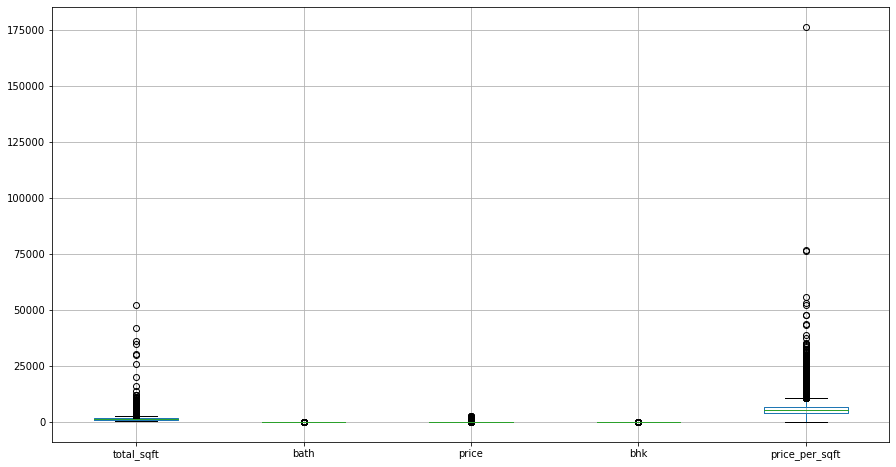

In [36]:
plt.figure(figsize = (15,8))
df5.boxplot()
plt.show()

### Removing the Outliers using IQR Method

In [37]:
q1 = df5.quantile(0.25)
q3 = df5.quantile(0.75)
iqr = q3 - q1
df5 = df5[~((df5 < (q1 - 1.5 *iqr)) | (df5 > (q3 + 1.5*iqr))).any(axis = 1)]
df5.shape

(10423, 7)

#### Checking for the Outliers

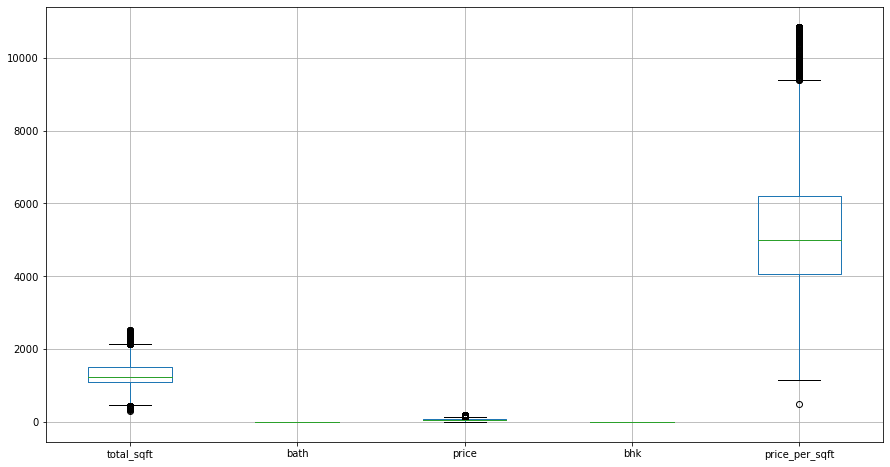

In [38]:
plt.figure(figsize = (15,8))
df5.boxplot()
plt.show()

### One Hot Encoding for the Categorical Column 

In [39]:
dummies = pd.get_dummies(df5['location'])
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [40]:
df5 = df5.drop(['location','size','price_per_sqft'],axis = 1)
df5

,total_sqft,bath,price,bhk
0,1056.0,2.0,39.07,2
2,1440.0,2.0,62.00,3
3,1521.0,3.0,95.00,3
4,1200.0,2.0,51.00,2
5,1170.0,2.0,38.00,2
...,...,...,...,...
13312,1262.0,2.0,47.00,2
13313,1345.0,2.0,57.00,3
13314,1715.0,3.0,112.00,3
13317,1141.0,2.0,60.00,2


In [41]:
df6 = pd.concat([dummies.drop('other',axis = 1),df5],axis = 1)
df6.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,total_sqft,bath,price,bhk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1056.0,2.0,39.07,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1440.0,2.0,62.00,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1521.0,3.0,95.00,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1200.0,2.0,51.00,2
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1170.0,2.0,38.00,2


In [42]:
df6.isnull().sum()

1st Block Jayanagar          0
1st Phase JP Nagar           0
2nd Phase Judicial Layout    0
5th Block Hbr Layout         0
5th Phase JP Nagar           0
                            ..
Yeshwanthpur                 0
total_sqft                   0
bath                         0
price                        0
bhk                          0
Length: 242, dtype: int64

## Builing a Model

In [43]:
X = df6.drop('price', axis = 1)
y = df6['price']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

print('The Shape of the X_train data is ', X_train.shape)
print('The Shape of the y_train data is ', y_train.shape)
print('The Shape of the X_test data is ', X_test.shape)
print('The Shape of the y_test data is ', y_test.shape)

The Shape of the X_train data is  (7296, 241)
The Shape of the y_train data is  (7296,)
The Shape of the X_test data is  (3127, 241)
The Shape of the y_test data is  (3127,)


In [45]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
model.score(X_train, y_train)

0.7058852622280434

### Creating the Score Card 

In [46]:
def get_score(model):
    r_sq = model.score(X_train, y_train)
    n = X_train.shape[0]
    k = X_train.shape[1]
    r_sq_adj = 1 - ((1-r_sq)*(n-1)/(n-k-1))
    return ([r_sq, r_sq_adj])

In [47]:
def get_train_rmse(model):
    train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, train_pred)
    rmse_train = round(np.sqrt(mse_train), 4)
    return(rmse_train)

In [48]:
def get_test_rmse(model):
    test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, test_pred)
    rmse_test = round(np.sqrt(mse_test), 4)
    return(rmse_test)

In [49]:
def mape(actual, predicted):
    return (np.mean(np.abs((actual - predicted) / actual)) * 100)

def get_test_mape(model):
    test_pred = model.predict(X_test)
    mape_test = mape(y_test, test_pred)
    return(mape_test)

In [50]:
score_card = pd.DataFrame(columns=['Model_Name', 'R-Squared',
                                       'Adj. R-Squared',
                                   'Difference of Test & Train RMSE',
                                   'Test_MAPE'])
def update_score_card(modelname, model):
    global score_card
    
    score_card = score_card.append({'Model_Name' :modelname,
                                   'R-Squared' :get_score(model)[0],
                                   'Adj. R-Squared':get_score(model)[1],
                                    'Difference of Test & Train RMSE': abs(get_test_rmse(model)-get_train_rmse(model)),
                                    'Test_MAPE': get_test_mape(model)},
                                  ignore_index= True)

In [51]:
update_score_card('Linear Regression -Base Model', model)
score_card

,Model_Name,R-Squared,Adj. R-Squared,Difference of Test & Train RMSE,Test_MAPE
0,Linear Regression -Base Model,0.705885,0.695837,0.5776,22.205802


## Regularization

### Ridge Regularization

In [52]:
ridge = Ridge(alpha = 1, max_iter = 500)
ridge.fit(X_train, y_train)

Ridge(alpha=1, max_iter=500)

In [53]:
update_score_card('Ridge Regression (alpha = 1)', ridge)
score_card

,Model_Name,R-Squared,Adj. R-Squared,Difference of Test & Train RMSE,Test_MAPE
0,Linear Regression -Base Model,0.705885,0.695837,0.5776,22.205802
1,Ridge Regression (alpha = 1),0.705178,0.695105,0.5297,22.202868


### Lasso Regularization

In [54]:
lasso = Lasso(alpha = 0.01, max_iter = 500)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, max_iter=500)

In [55]:
update_score_card('Lasso Regression (alpha = 0.01)', lasso)
score_card

,Model_Name,R-Squared,Adj. R-Squared,Difference of Test & Train RMSE,Test_MAPE
0,Linear Regression -Base Model,0.705885,0.695837,0.5776,22.205802
1,Ridge Regression (alpha = 1),0.705178,0.695105,0.5297,22.202868
2,Lasso Regression (alpha = 0.01),0.695497,0.685093,0.4489,22.629433


### Elastic Net Regularization

In [56]:
elastic = ElasticNet(alpha = 0.1, l1_ratio = 0.01, max_iter = 500)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=500)

In [57]:
update_score_card('Elastic Net Regression', elastic)
score_card

,Model_Name,R-Squared,Adj. R-Squared,Difference of Test & Train RMSE,Test_MAPE
0,Linear Regression -Base Model,0.705885,0.695837,0.5776,22.205802
1,Ridge Regression (alpha = 1),0.705178,0.695105,0.5297,22.202868
2,Lasso Regression (alpha = 0.01),0.695497,0.685093,0.4489,22.629433
3,Elastic Net Regression,0.621177,0.608235,0.2432,25.756287


### Find Optimal Value of Alpha for Ridge Regression

In [58]:
tuned_paramaters = [{'alpha':[1e-15, 1e-10, 1e-8, 1e-4,1e-3, 1e-2, 0.1, 1, 5, 10, 20, 40, 60, 80, 100]}]
ridge = Ridge()
ridge_grid = GridSearchCV(estimator = ridge, param_grid = tuned_paramaters, cv = 10)
ridge_grid.fit(X_train, y_train)
print('Best parameters for Ridge Regression: ', ridge_grid.best_params_, '\n')

Best parameters for Ridge Regression:  {'alpha': 1} 



In [59]:
update_score_card('Ridge Regression with Grid SearchCV', ridge_grid)
score_card

,Model_Name,R-Squared,Adj. R-Squared,Difference of Test & Train RMSE,Test_MAPE
0,Linear Regression -Base Model,0.705885,0.695837,0.5776,22.205802
1,Ridge Regression (alpha = 1),0.705178,0.695105,0.5297,22.202868
2,Lasso Regression (alpha = 0.01),0.695497,0.685093,0.4489,22.629433
3,Elastic Net Regression,0.621177,0.608235,0.2432,25.756287
4,Ridge Regression with Grid SearchCV,0.705178,0.695105,0.5297,22.202868


### Find Optimal Value of alpha for Lasso Regression 

In [60]:
tuned_paramaters = [{'alpha':[1e-15, 1e-10, 1e-8, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]}]
lasso = Lasso()
lasso_grid = GridSearchCV(estimator = lasso, param_grid = tuned_paramaters, cv = 10)
lasso_grid.fit(X_train, y_train)

print('Best parameters for Lasso Regression: ', lasso_grid.best_params_, '\n')

Best parameters for Lasso Regression:  {'alpha': 0.001} 



In [61]:
update_score_card('Lasso Regression with Grid SearchCV', lasso_grid)
score_card

,Model_Name,R-Squared,Adj. R-Squared,Difference of Test & Train RMSE,Test_MAPE
0,Linear Regression -Base Model,0.705885,0.695837,0.5776,22.205802
1,Ridge Regression (alpha = 1),0.705178,0.695105,0.5297,22.202868
2,Lasso Regression (alpha = 0.01),0.695497,0.685093,0.4489,22.629433
3,Elastic Net Regression,0.621177,0.608235,0.2432,25.756287
4,Ridge Regression with Grid SearchCV,0.705178,0.695105,0.5297,22.202868
5,Lasso Regression with Grid SearchCV,0.705736,0.695683,0.5580,22.193612


### Find Optimal Value of Alpha for Elastic Net Regression 

In [62]:
tuned_paramaters = [{'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 40, 60],
                      'l1_ratio':[0.0001, 0.0002, 0.001, 0.01, 0.1, 0.2]}]
elastic = ElasticNet()
elastic_grid = GridSearchCV(estimator = elastic, param_grid = tuned_paramaters, cv = 10)
elastic_grid.fit(X_train, y_train)

print('Best parameters for Elastic Net Regression: ', elastic_grid.best_params_, '\n')

Best parameters for Elastic Net Regression:  {'alpha': 0.0001, 'l1_ratio': 0.0001} 



In [63]:
update_score_card('Elastic Net Regression with Grid SearchCV', elastic_grid)
score_card

,Model_Name,R-Squared,Adj. R-Squared,Difference of Test & Train RMSE,Test_MAPE
0,Linear Regression -Base Model,0.705885,0.695837,0.5776,22.205802
1,Ridge Regression (alpha = 1),0.705178,0.695105,0.5297,22.202868
2,Lasso Regression (alpha = 0.01),0.695497,0.685093,0.4489,22.629433
3,Elastic Net Regression,0.621177,0.608235,0.2432,25.756287
4,Ridge Regression with Grid SearchCV,0.705178,0.695105,0.5297,22.202868
5,Lasso Regression with Grid SearchCV,0.705736,0.695683,0.5580,22.193612
6,Elastic Net Regression with Grid SearchCV,0.705469,0.695406,0.5407,22.196550


`From the above model Linear Regression Model gives better accuracy level of R- Squared and model performes better` 